In [ ]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));
import PyPlot
plt = PyPlot.plt
plt.style.use("default")
using BenchmarkTools

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [ ]:
using Gen

In [ ]:
@gen function f()
    x ~ normal(0,1)
    y ~ normal(x,0.5)
    return [x y]
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], false, Union{Nothing, Some{Any}}[], ##f#425, Bool[], false)

In [ ]:
tr, w = generate(f, (), choicemap())

sc   = get_score(tr)
sc_x = project(tr, select(:x))
sc_y = project(tr, select(:y))

print("
w                 = $w
score             = $sc
score_x + score_y = $(sc_x + sc_y)   
")


w                 = 0.0
score             = -1.795545984813676
score_x + score_y = -1.795545984813676   


In [ ]:
trs, ws, = importance_sampling(f, (), choicemap(), 1_000);

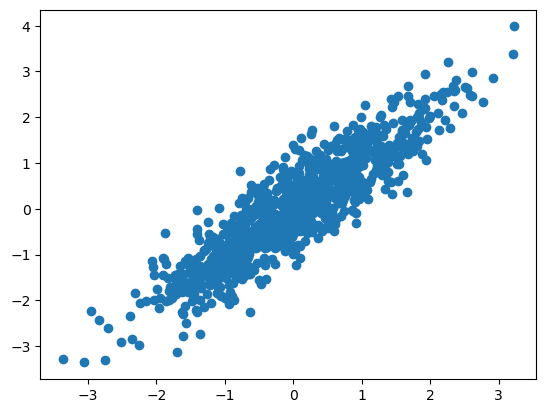

PyObject <matplotlib.collections.PathCollection object at 0x7faa01e6e1f0>

In [ ]:
zs     = get_retval.(trs)
log_ps = get_score.(trs)

zs = vcat(zs...)
plt.scatter(zs[:,1], zs[:,2])

# Map

In [ ]:
function fargs(args...)
    print(args)
end

fargs([1,2],3,4)

([1, 2], 3, 4)

In [ ]:
@gen function test(μ, σ)
    x ~ normal(μ, σ)
    return x
end

mapper = Map(test)
mapper([1,2,3],[1,2,3000])

Persistent{Any}[0.756576071514744, -0.3183732868739142, -565.7107198551076]

In [ ]:

@gen (static) function static_D_model() #Sim::Array{Float64,2})
    M = zeros(3,3)
    x = @trace(Map(test)([1,2,3]), :x)
end

@load_generated_functions 
tr = simulate(static_D_model, ());
get_choices(tr)

MethodError: MethodError: no method matching ##test#506(::Gen.GFSimulateState, ::Int64, ::Int64)
Closest candidates are:
  ##test#506(::Any, ::Any) at In[40]:2

# Mixtures and multivariates

In [ ]:
mixture_of_normals = HomogeneousMixture(normal, [0, 0])
mixture_of_normals([0.4, 0.6], [-1.0, 1.0], [1.0, 1.0])

-0.2460065144059398

In [ ]:
N = 1000
cov = rand(N,N)
cov = cov*cov'
mu = rand(N)
mvnormal(mu, cov)

1000-element Array{Float64,1}:
 21.203827183068352  
 20.188833970851352  
  6.509119471766665  
 11.460844601566492  
 21.38508290076398   
  0.39655853894283144
 16.19997876375273   
 11.164142736272538  
 27.773869798195467  
 24.67196381663001   
 15.636935354759245  
 11.285150174983062  
  2.3938250986773237 
  ⋮                  
 10.129317217685712  
  2.4873731360928826 
 22.060894977980762  
 23.604264862419118  
  7.356188006730056  
 16.852430294500852  
 14.804610210103327  
  0.9249928219059094 
 14.30056605117029   
  4.501468811489831  
 -2.704463957344326  
 15.332611349858368  

# Static vs Normal

In [ ]:
@gen function model_a(T::Int)
    D = zeros(T,T)
    for i=1:T, j=1:T
        D[i,j] = {:D => (i,j)} ~ normal(0,1)
    end
    return D
end;

In [ ]:
@gen function Dij_model(I)
    d ~ normal(0,1)
    return d
end

@gen (static) function model_b(T::Int)
    D ~ Map(Dij_model)(CartesianIndices((T,T)))
    return D
end

@load_generated_functions;

In [ ]:
T = 100
@btime generate(model_a, (T,), choicemap());
@btime generate(model_b, (T,), choicemap());

  2.438 s (18850221 allocations: 619.79 MiB)


InterruptException: InterruptException:

# More obs than addresses

In [ ]:
T = 5

5

In [ ]:
@gen function model(k::Int)
    D = zeros(T,T)
    for i=1:T, j=max(i-k,1):min(i+k,T)
        D[i,j] = {:D => (i,j)} ~ normal(0,1)
    end
    return D
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], ##model#427, Bool[0], false)

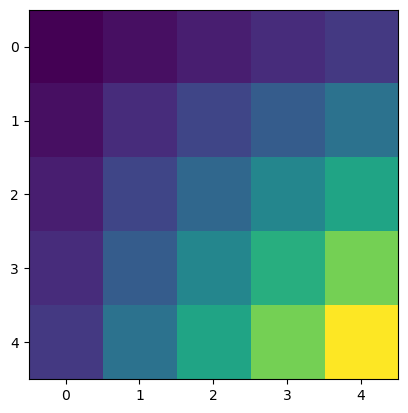

-1535.473463330117
-1535.473463330117

PyObject <matplotlib.image.AxesImage object at 0x7fa08eff9b50>

In [ ]:
obs = choicemap([ (:D => (i,j)) => i*j for i=1:T,j=1:T]...)

tr, w = generate(model, (T,), obs)
get_choices(tr)[:D => (1,1)]
print(w)
print("\n")
D = get_retval(tr)
# print(D)
print(get_score(tr))
# ---------
plt.imshow(D)

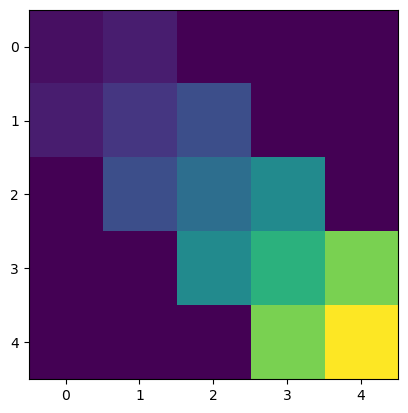

-1085.4462009316608

PyObject <matplotlib.image.AxesImage object at 0x7fa08f2dd6d0>

In [ ]:
tr_, w_,_,_ = update(tr, (1,), (UnknownChange(),), choicemap());



D_ = get_retval(tr_)
print(get_score(tr_))
# ---------
plt.imshow(D_)

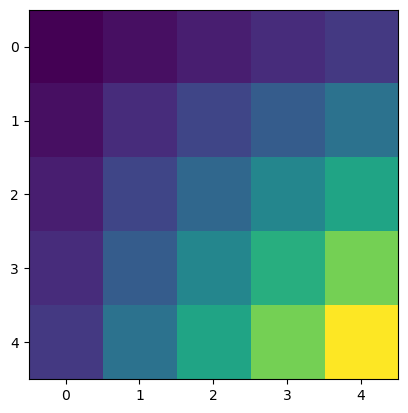

-1535.473463330117

PyObject <matplotlib.image.AxesImage object at 0x7fa08f44c640>

In [ ]:
tr__, w_,_,_ = update(tr_, (T,), (UnknownChange(),), obs);



D = get_retval(tr__)
print(get_score(tr__))
# ---------
plt.imshow(D)